# Introduction 📊

Welcome to this Time Series Analysis Notebook! Time series analysis is a powerful method used to analyze time-ordered data points. It's essential in forecasting, understanding underlying patterns, and much more. This first notebook covers:
- Visualization 📈
- Stationarity checking ✅
- Decomposition 🔄
- Autoregressive (AR) modeling 🔄
- Seasonal AutoRegressive Integrated Moving Average (SARIMAX) modeling ❄️

We'll walk through each step using a generated dataset with trend and seasonality. Let's dive in!

### Generating Fake Time Series Data 🎲

We'll start by creating a fake time series with trend and seasonality. This will serve as a playground for our analysis.


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from datetime import timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
# Generating some fake time series data with trend and seasonality
np.random.seed(42)
t = np.arange(0, 200)
y = 0.5*t + 10*np.sin(t/5) + np.random.normal(scale=5, size=200)
time_series = pd.Series(y)
date_rng = pd.date_range(start='1/1/2020', periods=200, freq='D')
time_series = pd.Series(y, index=date_rng)

### Visualizing Time Series 📉

We'll begin with a simple plot to understand our time series' overall structure.

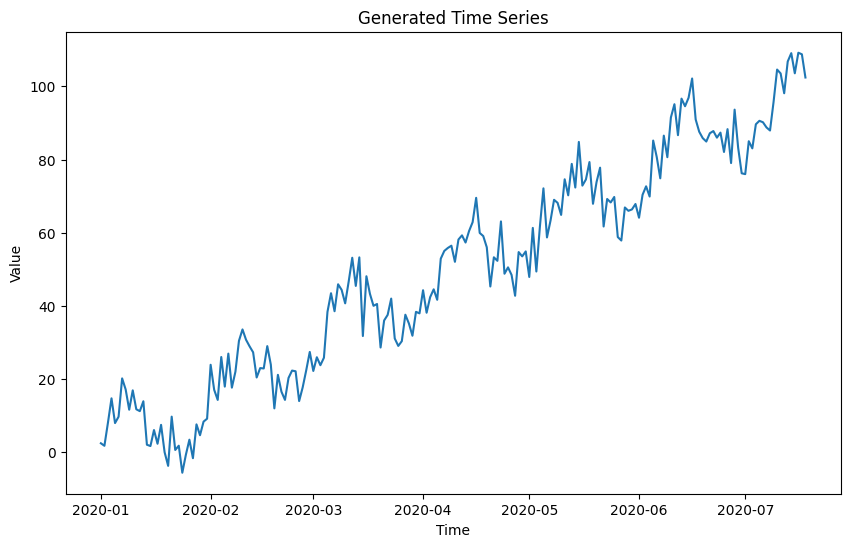

In [4]:
# Plotting the time series
plt.figure(figsize=(10,6))
plt.plot(time_series)
plt.title('Generated Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

### Checking for Stationarity 🧐

Stationarity is a crucial property of time series. It means that statistical properties such as mean and variance remain constant over time. We'll use the Augmented Dickey-Fuller (ADF) test to check for stationarity.

In [5]:
# Checking for stationarity with Augmented Dickey-Fuller Test
result = adfuller(time_series)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.5503056190376452
p-value: 0.8818202906227441
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


### Decomposing the Time Series 🔍

We can break down our time series into three main components: trend, seasonality, and noise. This decomposition helps in understanding the underlying structure of the series.

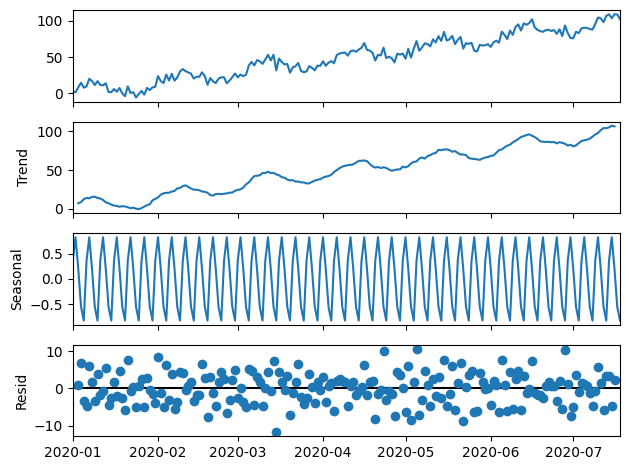

In [6]:
# Decomposing the time series to observe trend, seasonality, and residuals
decomposition = seasonal_decompose(time_series, model='additive', period=5)
decomposition.plot()
plt.show()

### Making the Series Stationary ⚖️

To make our series stationary, we'll apply differencing. This involves subtracting the previous observation from the current observation.

In [7]:
# Differencing to make the series stationary
time_series_diff = time_series.diff().dropna()

### Autocorrelation Plots 🔄

The autocorrelation function (ACF) and partial autocorrelation function (PACF) help us understand the relationship between an observation and its lags. These are crucial for modeling decisions.

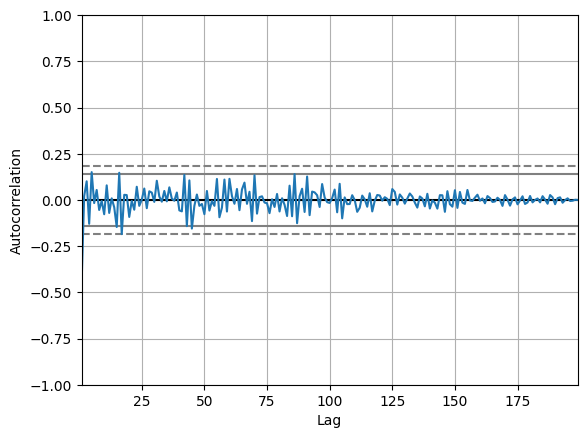

In [8]:
# Plotting the autocorrelation plot to help decide the order of ARIMA
autocorrelation_plot(time_series_diff)
plt.show()

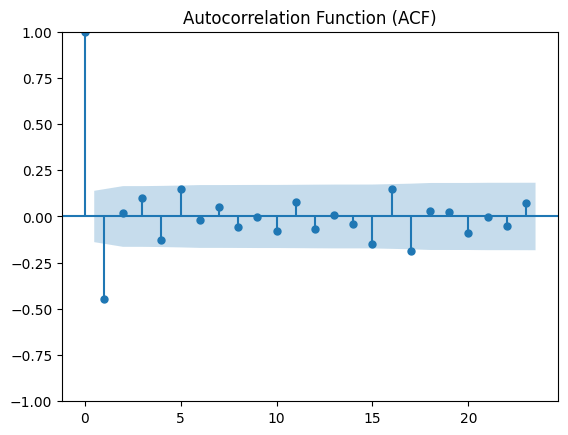

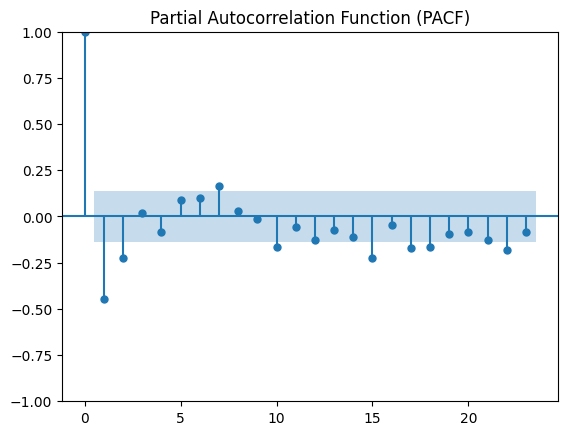

In [9]:
# Plotting ACF and PACF for the differenced series
plot_acf(time_series_diff)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(time_series_diff)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

### Selecting Optimal Lags for AR Model 🧠

We'll use the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) to determine the optimal number of lags for our AutoRegressive (AR) model. The lowest values of AIC and BIC typically indicate a good fit.

In [10]:
# Selecting the optimal number of lags for AR model using AIC and BIC
aic_values = []
bic_values = []
max_lag = 10
for lag in range(1, max_lag + 1):
    model_ar = AutoReg(time_series_diff, lags=lag)
    model_ar_fit = model_ar.fit()
    aic_values.append(model_ar_fit.aic)
    bic_values.append(model_ar_fit.bic)

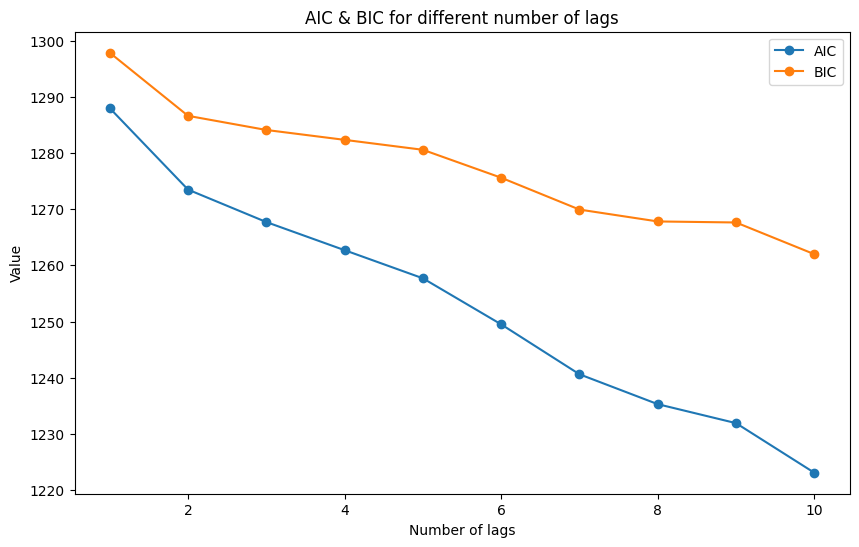

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_lag + 1), aic_values, marker='o', label='AIC')
plt.plot(range(1, max_lag + 1), bic_values, marker='o', label='BIC')
plt.title('AIC & BIC for different number of lags')
plt.xlabel('Number of lags')
plt.ylabel('Value')
plt.legend()
plt.show()

In [12]:
# Choosing the best number of lags based on AIC and BIC
best_lag_aic = aic_values.index(min(aic_values)) + 1
best_lag_bic = bic_values.index(min(bic_values)) + 1
print(f"Optimal number of lags based on AIC: {best_lag_aic}")
print(f"Optimal number of lags based on BIC: {best_lag_bic}")

Optimal number of lags based on AIC: 10
Optimal number of lags based on BIC: 10


### Building an AR Model 🚀

Now that we have our optimal number of lags, we'll fit an AR model to our time series.

Fitting an AR model:


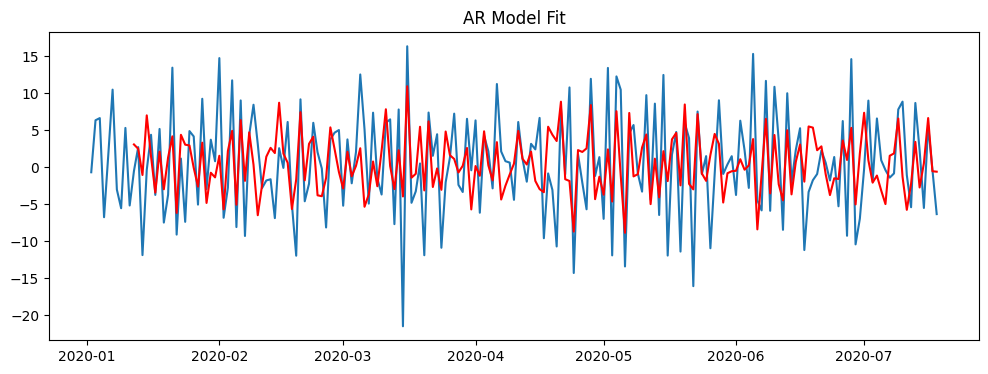

In [13]:
# AR Model
print("Fitting an AR model:")
model_ar = AutoReg(time_series_diff, lags=best_lag_aic)
model_ar_fit = model_ar.fit()
plt.figure(figsize=(12, 4)) # Set the figure size
plt.plot(time_series_diff)
plt.plot(model_ar_fit.fittedvalues, color='red')
plt.title('AR Model Fit')
plt.show()

### 30-day Forecasting 📆

Using our fitted AR model, we'll forecast 30 days into the future. This involves combining the trend, seasonality, and residual components.

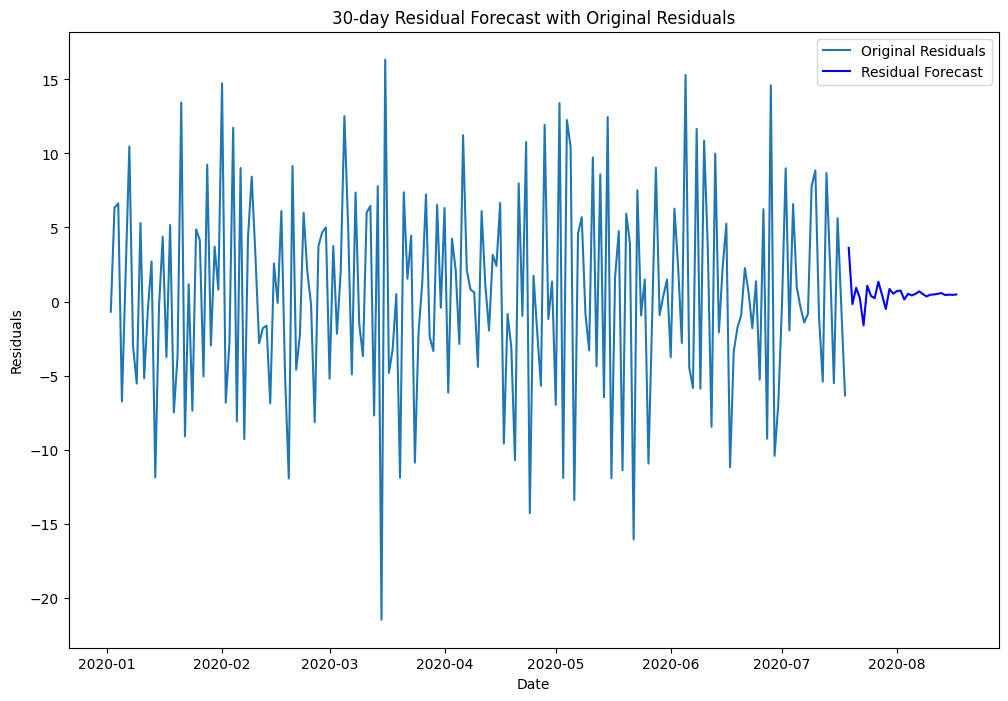

In [14]:
# Getting the 30-day ahead forecast
forecast = model_ar_fit.predict(start=len(time_series_diff), end=len(time_series_diff)+29)
forecast_dates = pd.date_range(time_series.index[-1] + timedelta(days=1), periods=30, freq='D')

# Plotting the residuals with confidence bands alongside the original series
plt.figure(figsize=(12, 8))
plt.plot(time_series_diff, label='Original Residuals')
plt.plot(forecast_dates, forecast, color='blue', label='Residual Forecast')
plt.title('30-day Residual Forecast with Original Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

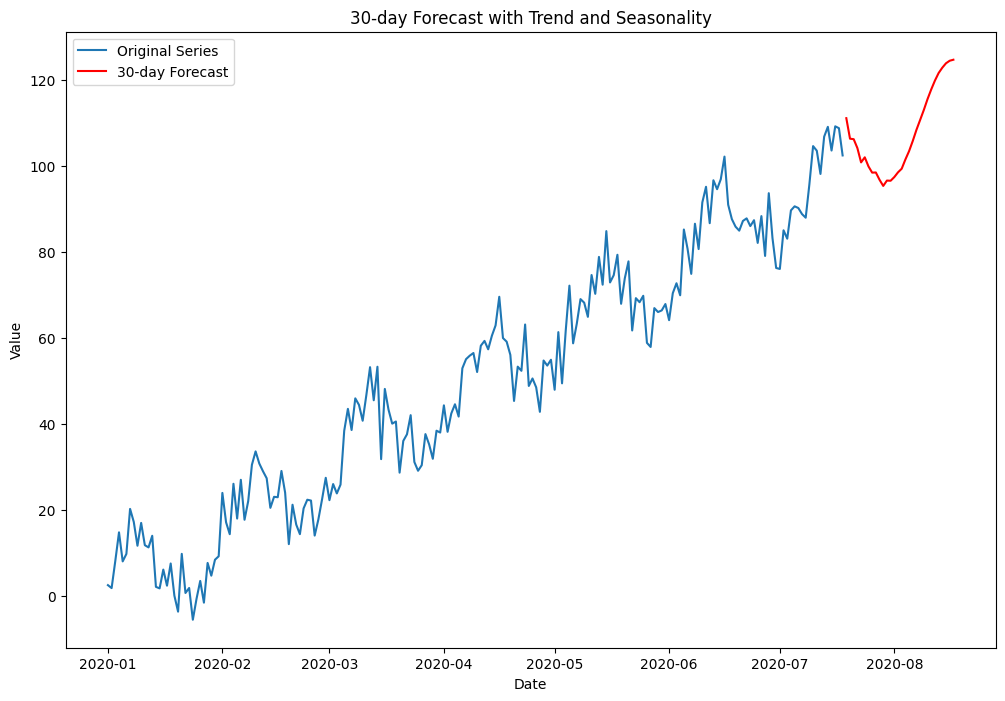

In [15]:
# Calculating the trend and seasonality components
trend = 0.5 * (t[-1] + 1 + np.arange(30))
seasonality = 10 * np.sin((t[-1] + 1 + np.arange(30)) / 5) # note in practice we don't know these and use attributes from seasonal_decompose

# Adding the residuals, trend, and seasonality to get the final forecast
final_forecast = forecast + trend + seasonality

# Plotting the extended original series and the forecast
plt.figure(figsize=(12, 8))
plt.plot(time_series, label='Original Series')
plt.plot(forecast_dates, final_forecast, color='red', label='30-day Forecast')
plt.title('30-day Forecast with Trend and Seasonality')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

🛸 **TASK:** Now that you've learned the essential steps of time series analysis for AR, here's a challenge for you: Implement Moving Averages and experiment with different window sizes.

### SARIMAX Modeling (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) 🌀

The SARIMAX model is a powerful statistical model for modeling time series data, especially when there is a clear seasonality pattern. SARIMAX stands for Seasonal AutoRegressive Integrated Moving Average with eXogenous variables, and it combines several components:

- **AR (Autoregressive):** The autoregressive part exploits the relationship between an observation and a number of lagged observations (previous time steps).

- **I (Integrated):** This refers to the differencing of raw observations to make the time series stationary.

- **MA (Moving Average):** The moving average part models the relationship between an observation and residual errors from moving average models applied to lagged observations.

- **Seasonal Components:** This involves models that consider the seasonality in the time series, accounting for patterns that repeat over known, fixed periods of time.

- **eXogenous variables:** These are external or independent variables that might affect the time series but are not influenced by it.

Here's a breakdown of the SARIMAX parameters:

- `order=(p, d, q)`: Refers to the AR order (p), differencing degree (d), and MA order (q).
- `seasonal_order=(P, D, Q, S)`: The seasonal component of the model, where P, D, Q represent the seasonal AR order, differencing degree, and MA order. S is the seasonality frequency.

SARIMAX can be used for both fitting and forecasting time series data, considering complex patterns, trends, and even external factors.

For more detailed information and fine-tuning the model parameters, it is highly advisable to refer to the official [Statsmodels documentation for SARIMAX](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html).

This can help in understanding more advanced concepts, working with multiple seasonalities, including holidays effect, and various diagnostic tests that aid in selecting the best model.


In [16]:
# Fitting the SARIMAX model with the best order
model_sarimax = SARIMAX(time_series, order=(3, 1, 3), seasonal_order=(1, 1, 1, 30))
model_sarimax_fit = model_sarimax.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80730D+00    |proj g|=  1.35802D-01

At iterate    5    f=  2.76062D+00    |proj g|=  8.59347D-02

At iterate   10    f=  2.74985D+00    |proj g|=  9.95497D-03

At iterate   15    f=  2.74415D+00    |proj g|=  3.81364D-03

At iterate   20    f=  2.74397D+00    |proj g|=  1.76809D-03

At iterate   25    f=  2.74382D+00    |proj g|=  5.21577D-03

At iterate   30    f=  2.74378D+00    |proj g|=  1.38827D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [17]:
print(model_sarimax_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  200
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 30)   Log Likelihood                -548.757
Date:                              Mon, 21 Aug 2023   AIC                           1115.514
Time:                                      09:17:48   BIC                           1143.683
Sample:                                  01-01-2020   HQIC                          1126.945
                                       - 07-18-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5192      0.804     -0.646      0.518      -2.094       1.056
ar.L2          0.33

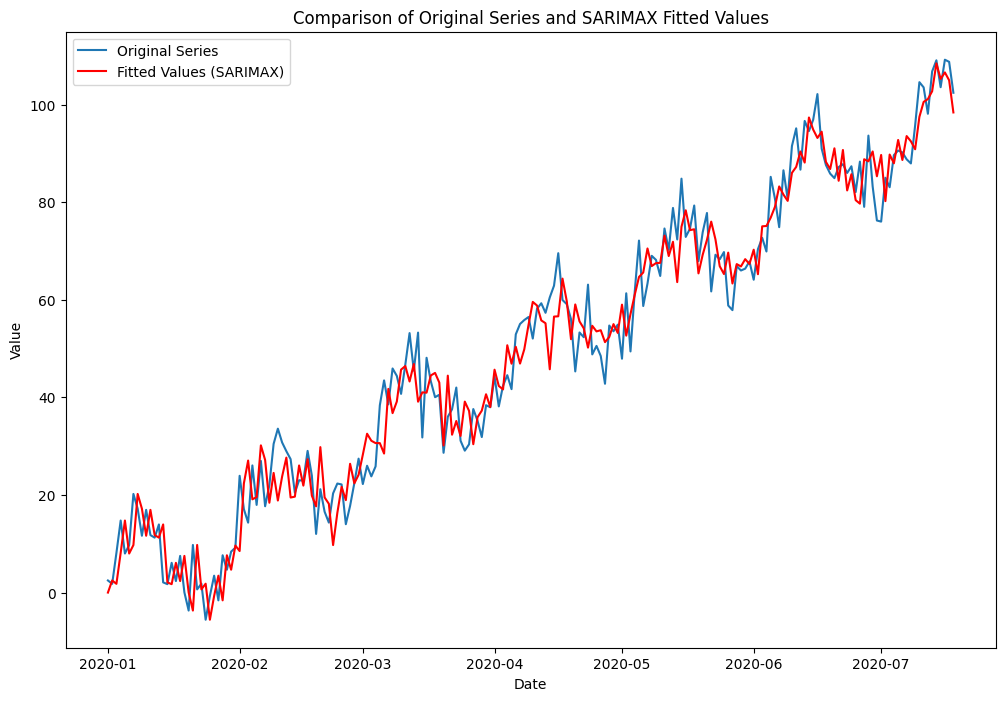

In [18]:
# Getting the SARIMAX fitted values
fitted_values = model_sarimax_fit.fittedvalues

plt.figure(figsize=(12, 8))
plt.plot(time_series, label='Original Series')
plt.plot(fitted_values, color='red', label='Fitted Values (SARIMAX)')
plt.title('Comparison of Original Series and SARIMAX Fitted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


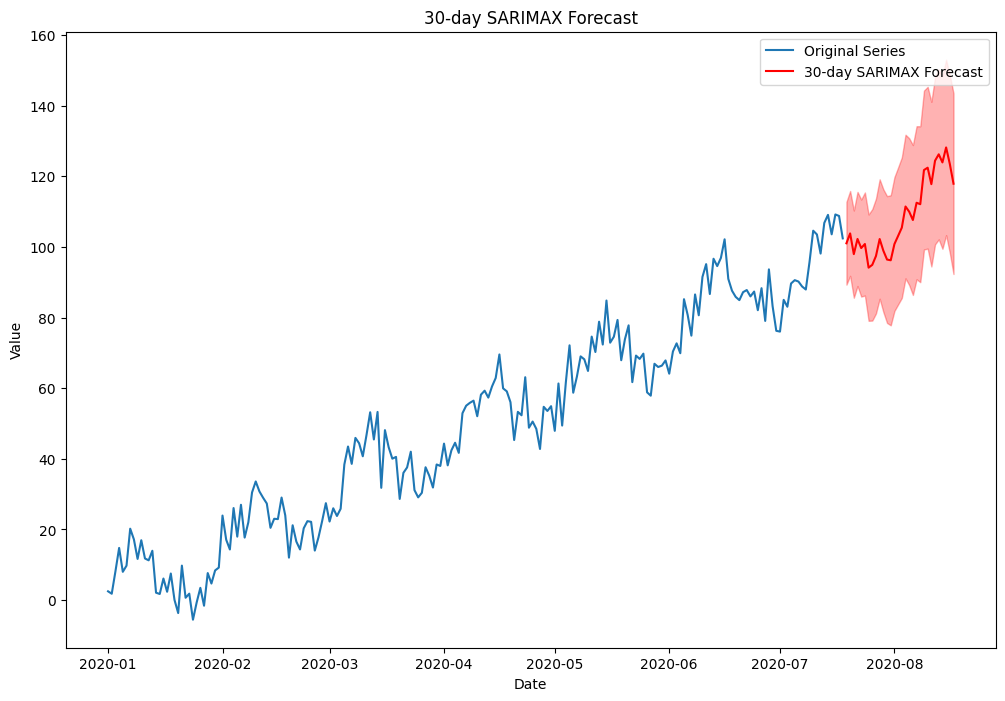

In [19]:
# Making 30-day ahead forecast using the SARIMAX model
forecast_sarimax = model_sarimax_fit.get_forecast(steps=30).summary_frame()['mean']
conf_int_sarimax = model_sarimax_fit.get_forecast(steps=30).summary_frame()[['mean_ci_lower', 'mean_ci_upper']]

# Plotting the original series and the 30-day ahead SARIMAX forecast
plt.figure(figsize=(12, 8))
plt.plot(time_series, label='Original Series')
plt.plot(forecast_dates, forecast_sarimax, color='red', label='30-day SARIMAX Forecast')
plt.fill_between(forecast_dates, conf_int_sarimax['mean_ci_lower'], conf_int_sarimax['mean_ci_upper'], color='red', alpha=0.3)
plt.title('30-day SARIMAX Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()